In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import config

plt.style.use('seaborn-v0_8')

In [2]:
result_path = os.path.join(config.RESULTS_PATH, 'syntheticData')

In [3]:
from torch.utils.data import Dataset
from dataset import HSIDataset
from scipy import io as sio

class SyntheticDataset(HSIDataset):
    def __init__(self, root_dir, transform=None):
        super(SyntheticDataset, self).__init__()
        data = sio.loadmat(os.path.join(root_dir, "Y.mat"))

        self.n_row, self.n_col , self.n_bands = data['nRow'].item(), data['nCol'].item(), data['nBand'].item()
        self.X = np.abs(data['Y'].T) # Because of the noise, there are negative values
        self.X = self.X.reshape(self.n_row, self.n_col, -1)
        self.X = self.preprocessing(self.X, max_value=1).reshape(-1, self.X.shape[-1]) # (nRow*nCol, nBand)

        self.E = sio.loadmat(os.path.join(root_dir, "M.mat"))['M_avg'].T
        self.A = sio.loadmat(os.path.join(root_dir, "A.mat"))['A'].T

        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.E = torch.tensor(self.E, dtype=torch.float32)
        self.A = torch.tensor(self.A, dtype=torch.float32)
        self.n_endmembers = self.E.shape[0]

        self.transform = transform

    def __len__(self):
        return self.n_row * self.n_col

    def __getitem__(self, idx):
        sample = self.X[idx]
        if self.transform:
            sample = self.transform(sample)

        return sample

    def endmembers(self):
        return self.E

    def abundance(self):
        return self.A.numpy().reshape(self.n_row, self.n_col, -1)

    def image(self):
        return self.X.numpy().reshape(self.n_row, self.n_col, -1)

In [131]:
from HySpecLab.metrics import UnmixingLoss, NormalizedEntropy
from HySpecLab.metrics.regularization import SimplexVolumeLoss, SimilarityLoss

from HySpecLab.unmixing import ContrastiveUnmixing
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch import sigmoid
from torch.utils.data import Dataset, DataLoader

def train(model:nn.Module, n_endmembers:int, dataset:Dataset, n_batchs:int = 64, n_epochs:int = 100, lr=1e-3, simplex_weight=1e-5):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)
    model.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = UnmixingLoss() 
    volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers).to(device)
    similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')
    vol_reg_norm = volume_reg(torch.sigmoid(model.ebk.detach()))
    print(vol_reg_norm)
    


    dataloader = DataLoader(dataset, batch_size=int(len(dataset)/n_batchs), shuffle=True)

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )

    similarity_weight = 5e-1

    scaler = torch.cuda.amp.GradScaler()

    for epoch in epoch_iterator:
        epoch_loss = 0.
        for i, (x) in enumerate(dataloader):
            x = x.to(device)
            optimizer.zero_grad()
            y = model(x)
            loss = criterion(y, x) + simplex_weight*(volume_reg(sigmoid(model.ebk))/vol_reg_norm) + similarity_weight*similarity_reg(model.ebk)
            epoch_loss += loss.detach().item()

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
        epoch_iterator.set_postfix(tls="%.4f" % (epoch_loss/(i+1)))

In [132]:
from scipy import io as sio

synthetic_data_path = "/home/abian/Data/Dataset/HSI/SyntheticData/"
data = sio.loadmat(synthetic_data_path + "Y.mat")
M = sio.loadmat(synthetic_data_path + "M.mat")['M_avg']
A = sio.loadmat(synthetic_data_path + "A.mat")['A'].T

X = data['Y'].T
X = X.reshape(data['nRow'].item(), data['nCol'].item(), -1, order='F')
A = A.reshape(data['nRow'].item(), data['nCol'].item(), -1, order='F')

# Image to RGB

In [133]:
dataset = SyntheticDataset(synthetic_data_path, transform=None)

In [134]:
jasper_wv = np.linspace(380, 2500, 224) # 224 bands from 380 to 2500 nm

data = sio.loadmat(os.path.join(config.JasperRidge_PATH, 'jasperRidge2_R198.mat'))
selected_bands = data['SlectBands'].squeeze()
selected_jasper_wv = jasper_wv[selected_bands].tolist()

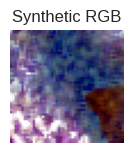

In [135]:
from HSI2RGB import HSI2RGB

# Use the D65 illuminant
illuminant = 65

# Do minor thresholding
threshold = 0.02
X = dataset.image()
(ydim, xdim, zdim) = X.shape

# Reorder data so that each column holds the spectra of of one pixel
HSI_data = np.reshape(X, [-1,zdim], order='F')
rgb = HSI2RGB(selected_jasper_wv, HSI_data, xdim, ydim, illuminant, threshold)

fig = plt.figure(figsize=(7,5))
plt.subplot(3,4,1)
plt.imshow(rgb)
plt.axis('off')
plt.title('Synthetic RGB')
plt.show()

fig.savefig(os.path.join(result_path, 'imgs/synthetic_rgb.png'), dpi=300, bbox_inches='tight')

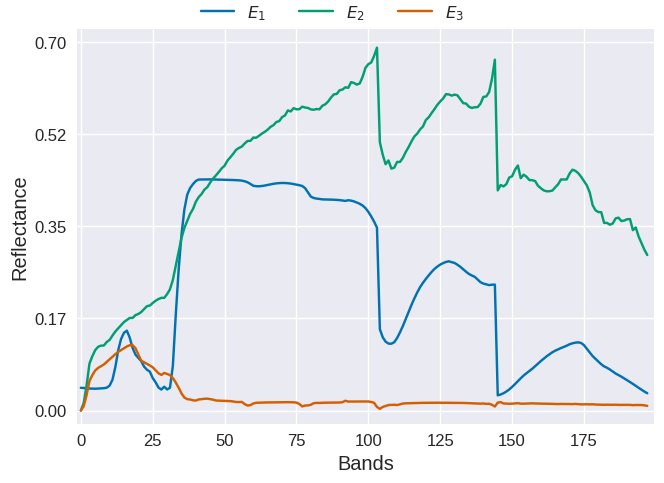

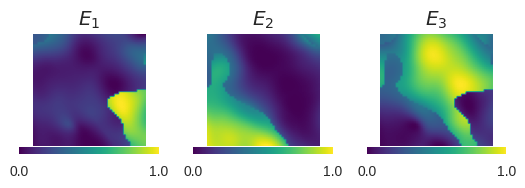

In [136]:
from utils import plot_endmembers, show_abundance
fig = plot_endmembers(dataset.endmembers(), ticks_range=(0, .7))
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/E_ref.pdf'), bbox_inches='tight')

fig = show_abundance(dataset.abundance())
fig.savefig(os.path.join(result_path, 'imgs/A_ref.png'), dpi=300, bbox_inches='tight')

## Endmember estimation

## VCA

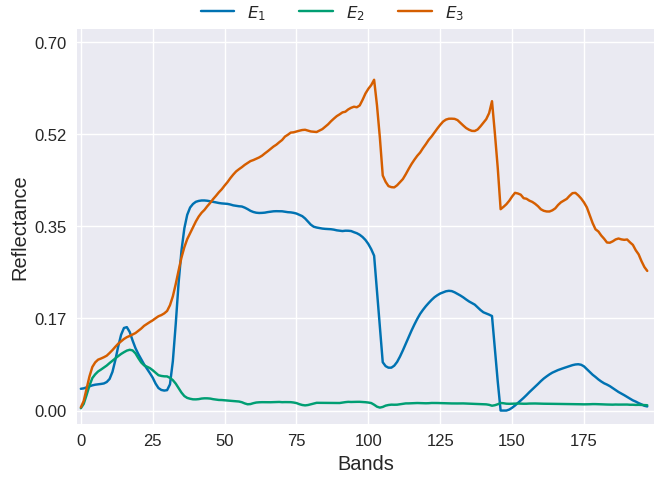

In [40]:
from HySpecLab.eea import VCA
_X = X.reshape(-1, X.shape[-1])
n_endmembers = 3
vca = VCA(n_endmembers, snr_input=30, random_state=25)
vca.fit(_X)
endmembers = vca.endmembers()

plot_endmembers(endmembers, ticks_range=(0, .7))
plt.show()

## NFINDR

In [137]:
from utils import plot_endmembers
from pysptools import eea
n_endmembers = dataset.n_endmembers

ee = eea.NFINDR()
endmember = ee.extract(X, n_endmembers)
endmember_init = torch.from_numpy(endmember).float()

In [138]:
sad_result = sad(endmember_init, dataset.endmembers())
e_idx = torch.min(sad_result, dim=0) # Index for reordering the ground truth
e_idx, sad_result

(torch.return_types.min(
 values=tensor([0.0651, 0.0349, 0.0591]),
 indices=tensor([0, 2, 1])),
 tensor([[0.0651, 0.4921, 1.1298],
         [1.1119, 1.0733, 0.0591],
         [0.4404, 0.0349, 1.0778]]))

In [139]:
sad_result

tensor([[0.0651, 0.4921, 1.1298],
        [1.1119, 1.0733, 0.0591],
        [0.4404, 0.0349, 1.0778]])

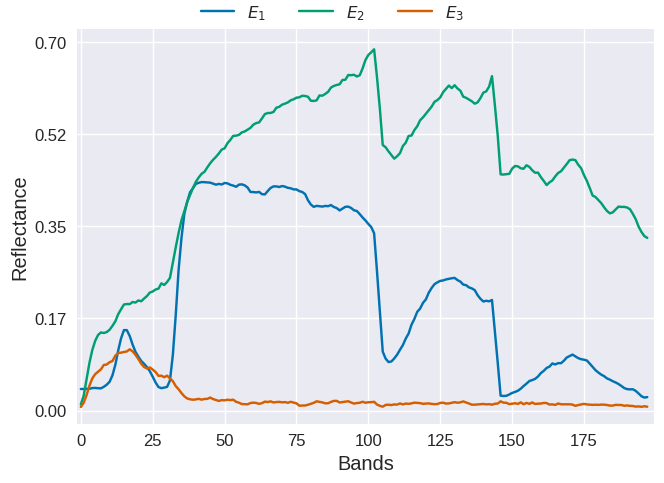

In [140]:
from HySpecLab.metrics import sad

sad_result = sad(endmember_init, dataset.endmembers())
e_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth
endmember_init = endmember_init[e_idx]
logit_endmember_init = torch.log((endmember_init / (1-endmember_init) + 1e-12))

fig = plot_endmembers(endmember_init, ticks_range=(0, .7))
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/E_nfindr_est.pdf'), bbox_inches='tight')

# Train

In [154]:
n_bands = dataset.n_bands
model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init)
train(model, n_endmembers, dataset, n_batchs=50, n_epochs=50, lr=1e-3, simplex_weight=1e-2)

tensor(31.6364, device='cuda:0')


100%|██████████| 50/50 [00:18<00:00,  2.75epoch/s, tls=0.0810]


## save model

In [170]:
torch.save(model.state_dict(), os.path.join(result_path, 'weights/clhu.pth'))

# Testing

In [167]:
criterion = UnmixingLoss()
entropy_reg  = NormalizedEntropy(S=n_endmembers)
volume_reg = SimplexVolumeLoss(dataset[:], n_endmembers)
similarity_reg = SimilarityLoss(n_endmembers, temperature=.1, reduction='mean')

In [168]:
_X = dataset.X

model.eval()
model = model.cpu()
reconstruc = model(_X)
with torch.no_grad():
    print(criterion(reconstruc, _X).cpu(), entropy_reg(model.A).cpu(), volume_reg(sigmoid(model.ebk)).cpu(),
         similarity_reg(sigmoid(model.ebk)).cpu())

tensor(0.0268) tensor(0.6271) tensor(30.6698) tensor(0.1897)


In [169]:
volume_reg(endmember_init), similarity_reg(endmember_init)

(tensor(31.6364), tensor(0.1887))

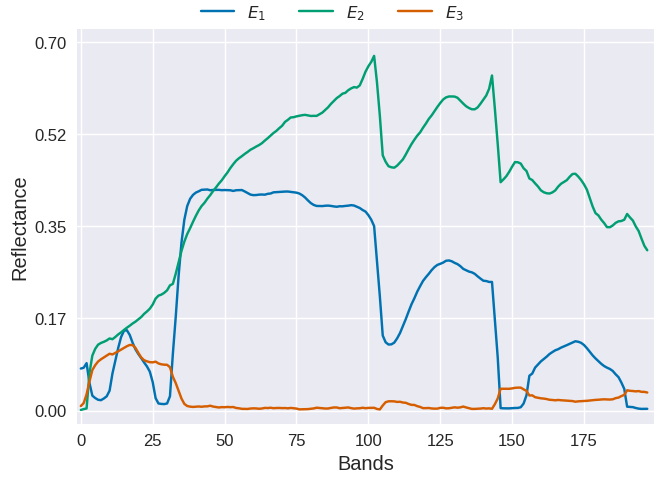

In [159]:
ebk = sigmoid(model.ebk).detach().cpu()

fig = plot_endmembers(ebk, ticks_range=(0, .7))
plt.show(fig)
fig.savefig(os.path.join(result_path, 'imgs/E_clhu_est.pdf'), bbox_inches='tight')

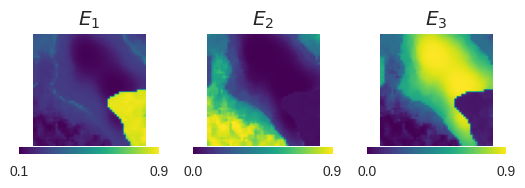

In [163]:
from torch.nn.functional import softmax
from utils import show_abundance

test = softmax(model.A.detach(), dim=1).cpu().numpy().reshape(dataset.n_row, dataset.n_col, -1)

fig = show_abundance(test)
plt.show(fig)

fig.savefig(os.path.join(result_path, 'imgs/A_clhu_est.png'), dpi=300, bbox_inches='tight')


In [195]:
y = model(_X)
y = y.detach().cpu()


from torch.nn.functional import mse_loss
def rmse(x: torch.Tensor, y: torch.Tensor, dim=1):
    '''
        Root Mean Squared Error (RMSE)

        Parameters
        ----------
            x: torch.Tensor, shape (batch_size, n_bands)
                input tensor.

            y: torch.Tensor, shape (batch_size, n_bands)
                target tensor.
            
            dim: int
                dimension to compute the mean. if 'None' the mean 
                is computed over all the elements.
    '''
    return torch.sqrt(mse_loss(x, y, reduction='none').mean(dim))

rmse(y, _X, dim=0)

tensor([0.0153, 0.0139, 0.0193, 0.0062, 0.0081, 0.0095, 0.0105, 0.0109, 0.0103,
        0.0100, 0.0092, 0.0082, 0.0086, 0.0088, 0.0093, 0.0099, 0.0102, 0.0103,
        0.0101, 0.0100, 0.0098, 0.0096, 0.0096, 0.0098, 0.0099, 0.0105, 0.0136,
        0.0144, 0.0139, 0.0139, 0.0140, 0.0137, 0.0105, 0.0118, 0.0144, 0.0169,
        0.0188, 0.0196, 0.0200, 0.0201, 0.0201, 0.0200, 0.0201, 0.0201, 0.0202,
        0.0200, 0.0199, 0.0198, 0.0198, 0.0196, 0.0195, 0.0195, 0.0194, 0.0192,
        0.0191, 0.0192, 0.0190, 0.0188, 0.0187, 0.0185, 0.0186, 0.0186, 0.0188,
        0.0187, 0.0185, 0.0185, 0.0186, 0.0186, 0.0187, 0.0185, 0.0186, 0.0186,
        0.0187, 0.0185, 0.0186, 0.0184, 0.0184, 0.0181, 0.0180, 0.0177, 0.0176,
        0.0177, 0.0177, 0.0178, 0.0178, 0.0179, 0.0179, 0.0180, 0.0179, 0.0179,
        0.0182, 0.0184, 0.0186, 0.0186, 0.0188, 0.0191, 0.0190, 0.0190, 0.0189,
        0.0194, 0.0193, 0.0194, 0.0193, 0.0179, 0.0167, 0.0151, 0.0146, 0.0144,
        0.0144, 0.0142, 0.0144, 0.0143, 

In [179]:
y.shape

torch.Size([50, 50, 198])

In [161]:
from HySpecLab.metrics import sad

sad_result = sad(ebk, torch.tensor(endmembers, dtype=torch.float))
print(sad_result)
np.argmin(sad_result, axis=0)

tensor([[0.0917, 1.1160, 0.4544],
        [0.5351, 1.0767, 0.0278],
        [1.3102, 0.3055, 1.1963]])


tensor([0, 2, 1])

In [162]:
sad_result = sad(endmember_init, torch.tensor(endmembers, dtype=torch.float))
print(sad_result)
np.argmin(sad_result, axis=0)

tensor([[0.0402, 1.1060, 0.4878],
        [0.5099, 1.0566, 0.0389],
        [1.0918, 0.0487, 1.0876]])


tensor([0, 2, 1])

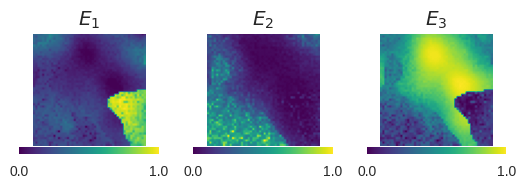

In [172]:
test = sio.loadmat(os.path.join(synthetic_data_path, 'A_est', 'FCLS.mat'))['A'].T
# from utils import plot_abundance
A = test.reshape(50,50,-1,order='C')
fig = show_abundance(A)
plt.show(fig)

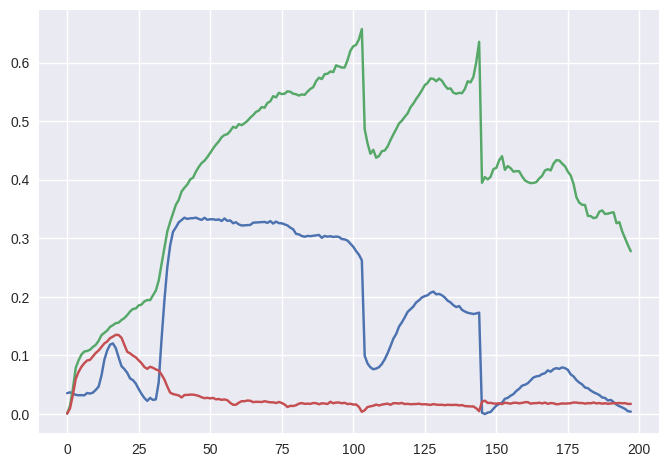

In [36]:
data = sio.loadmat(os.path.join(synthetic_data_path, 'M_est', 'MESMA.mat'))
M = data['M']
plt.plot(M[:,:,2000])
plt.show()

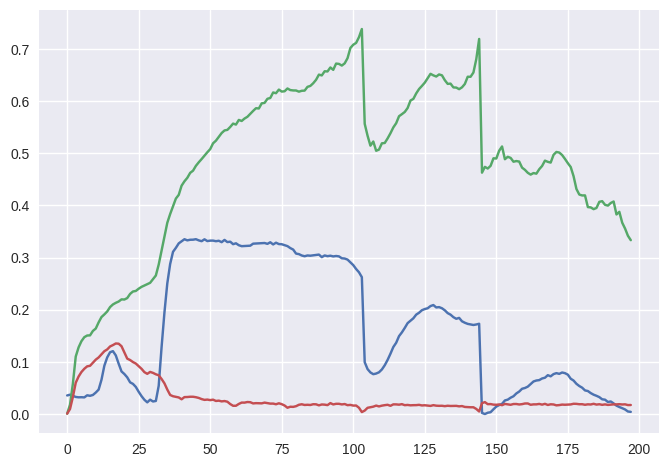

In [37]:
plt.plot(M[:,:,1000])
plt.show()